In [1]:
import json
import os
import tensorflow as tf
import pickle

In [2]:
import config as c
import coco_helper as ch

In [3]:
import matplotlib.pyplot as plt

In [4]:
from IPython.display import Image, display
def show_by_id(id):
    display(Image(filename=ch.id_to_filename(id)))

-----

In [4]:
with open(c.TRANSFORMED_TRAIN_ANNOTATIONS_PATH, 'rb') as f:
    combined_dict = pickle.load(f)

In [5]:
ids=[]
sizes=[]
keypoints=[]
joints=[]
for idd,l in combined_dict.items():
    ids.append(idd)
    sizes.append(l[0])
    keypoints.append(l[1])
    joints.append(l[2])

In [6]:
rt_keypoints=tf.ragged.constant(keypoints)

In [7]:
rt_joints=tf.ragged.constant(joints)

In [8]:
ds=tf.data.Dataset.from_tensor_slices((ids, sizes,rt_keypoints,rt_joints))

---

In [9]:
it=iter(ds)

In [11]:
sample_tensor=next(it)

NameError: name 'it' is not defined

In [6]:
#constants
x_grid=tf.linspace(0.0,1.0,300) 
y_grid=tf.linspace(0.0,1.0,300)

xx,yy=tf.meshgrid(x_grid,y_grid)
grid=tf.stack((xx,yy),axis=-1)
#GAUSSIAN_SPOT_SIGMA_SQ=tf.constant(0.01)

@tf.function
def draw_spots_v4(kpts_tensor):
    kpts_tensor=kpts_tensor.to_tensor()
    results = tf.TensorArray(tf.float32, size=17)
    for i in tf.range(17):
        kpts_layer = kpts_tensor[i]
        total_dist=tf.ones((300,300),dtype=tf.float32)

        for kpt in kpts_layer:
            if kpt[2]==tf.constant(0.0):
                continue
            #must add condition to deal with zeros
            ortho_dist=grid-kpt[0:2] 
            spot_dist=tf.linalg.norm(ortho_dist,axis=-1)         
            total_dist=tf.math.minimum(spot_dist,total_dist)

        results=results.write(i, total_dist)
    raw=tf.exp((-(results.stack()**2)/c.GAUSSIAN_SPOT_SIGMA_SQ))
    return tf.where(raw < 0.001, 0.0, raw)

# SUCCESS!!!

In [5]:
test=tf.ragged.constant([[[0.5197505354881287, 0.3812499940395355, 2.0]], [[0.5509355664253235, 0.34843748807907104, 2.0]], [[0.48856547474861145, 0.3671875, 2.0]], [[0.6424116492271423, 0.35468751192092896, 2.0]], [[0.48856547474861145, 0.39531248807907104, 2.0]], [[0.7380457520484924, 0.526562511920929, 2.0]], [[0.4469854533672333, 0.534375011920929, 2.0]], [[0.8461538553237915, 0.7718750238418579, 2.0]], [[0.442827433347702, 0.8125, 2.0]], [[0.9251559376716614, 0.964062511920929, 2.0]], [[0.5072765350341797, 0.698437511920929, 2.0]], [[0.7027027010917664, 0.942187488079071, 2.0]], [[0.55509352684021, 0.949999988079071, 2.0]], [[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]]])

In [13]:
r=draw_spots_v4(test)
r[13][150][100]

<tf.Tensor: id=380, shape=(), dtype=float32, numpy=0.0>

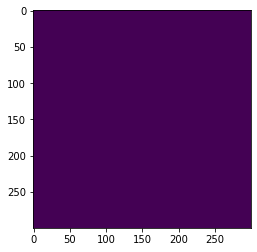

In [12]:
plt.imshow(r.numpy()[13])

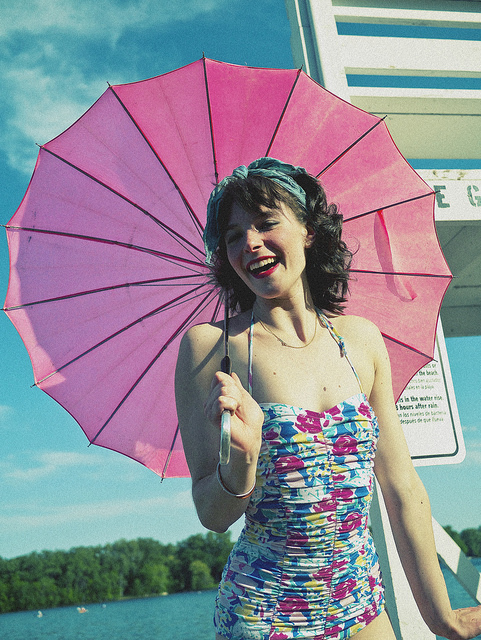

In [37]:
show_by_id(36)

EXperiments